# Hog_with_knn

## import libraries

In [10]:
import numpy as np
import cv2
import tensorflow as tf
from collections import Counter
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern
from skimage.feature import hog

## Load the Caltech101 dataset


In [12]:
dataset, info = tfds.load('caltech101', with_info=True, as_supervised=True)


## Split the dataset into training and testing sets


In [14]:
train_data = dataset['train']
test_data = dataset['test']

## Resize with padding function


In [16]:
def resize_with_padding(image, target_size=(64, 64)):
    h, w = image.shape[:2]
    scale = min(target_size[1] / w, target_size[0] / h)
    resized_image = cv2.resize(image, (int(w * scale), int(h * scale)))
    
    delta_w = target_size[1] - resized_image.shape[1]
    delta_h = target_size[0] - resized_image.shape[0]
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)
    padded_image = cv2.copyMakeBorder(resized_image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    return padded_image

## Process the dataset


In [18]:
def process_data(data, image_size=(64, 64)):
    images = []
    labels = []

    for image, label in data:
        # Resize with padding
        image_resized = resize_with_padding(image.numpy(), image_size).astype('float32') / 255.0
        images.append(image_resized)
        labels.append(label.numpy())
    
    return np.array(images), np.array(labels)

## Preprocess the training and testing datasets


In [20]:
X_train, y_train = process_data(train_data, image_size=(64, 64))
X_test, y_test = process_data(test_data, image_size=(64, 64))

## Feature extraction using HOG only


In [22]:
def extract_hog_features(image, image_size=(64, 64)):
    # Convert image to grayscale
    gray_image = cv2.cvtColor((image * 255).astype('uint8'), cv2.COLOR_RGB2GRAY)
    
    # Define HOGDescriptor parameters
    winSize = (32, 32)
    blockSize = (16, 16)
    blockStride = (8, 8)
    cellSize = (8, 8)
    nbins = 9

    # Initialize HOGDescriptor
    hog_descriptor = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins)
    
    # Compute HOG features
    hog_features = hog_descriptor.compute(gray_image).flatten()
    
    return hog_features

## Feature extraction for training and testing datasets using HOG only


In [24]:
def extract_hog_features_for_dataset(images, image_size=(64, 64)):
    features = []
    for image in images:
        features.append(extract_hog_features(image, image_size))
    return np.array(features)

## Extract HOG features for training and testing datasets


In [26]:
features_train = extract_hog_features_for_dataset(X_train, image_size=(64, 64))
features_test = extract_hog_features_for_dataset(X_test, image_size=(64, 64))

## Implement KNN classifier


In [28]:

def euclidean_distance(x1, x2):
    distance = np.sqrt(np.sum((x1-x2)**2))
    return distance

class KNN:
    def __init__(self, k=3): #we make default 3 the votes might be 2:1, ensuring a clear winner smaller than will be no winner or overfitting
        self.k = k

    def fit(self, X, y): #fit means stores our trainnig set
        self.X_train = X    
        self.y_train = y

    def _predict(self, x):
        # compute the distance
        distances = [euclidean_distance(x, x_train) for x_train in self.X_train] #x is the test set from xtrain to last value in x_train 
    
        # get the closest k
        k_indices_feature = np.argsort(distances)[:self.k] ## sorting ascending order to find the nearest point and determine which class belongs
        k_nearest_labels = [self.y_train[i] for i in k_indices_feature]

        # majority voye
        most_common = Counter(k_nearest_labels).most_common()  ## to count the occurrences of each element in an iterable (like a list).
        return most_common[0][0]  ##first element in first label
    
    def predict(self, X):
        predictions = [self._predict(x) for x in X]
        return predictions

    

## Train and predict with KNN


In [30]:
classifier = KNN(k=5)
classifier.fit(features_train, y_train.flatten())
y_pred = classifier.predict(features_test)


## Evaluate the classifier


In [32]:
accuracy = accuracy_score(y_test.flatten(), y_pred)
print(f"Accuracy using HOG features with KNN: {accuracy * 100:.2f}%")

Accuracy using HOG features with KNN: 53.71%


## Print classification report


In [34]:
print("\nClassification Report:")
print(classification_report(y_test.flatten(), y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.40      0.56        25
           1       0.97      0.93      0.95       770
           2       0.27      0.25      0.26        12
           3       0.00      0.00      0.00        12
           4       0.64      0.09      0.15       438
           5       0.18      0.41      0.25        17
           6       0.29      0.21      0.24        24
           7       0.05      0.06      0.05        16
           8       0.00      0.00      0.00         3
           9       0.30      0.22      0.26        98
          10       0.36      0.29      0.32        68
          11       0.18      0.15      0.17        13
          12       0.34      0.45      0.39        55
          13       0.93      0.23      0.37        61
          14       0.50      0.10      0.17        20
          15       0.10      0.15      0.12        13
          16       0.91      0.98      0.94        93
   

## Visualize a random image, its HOG features, and the KNN prediction


In [36]:
def show_image_with_hog_features_and_prediction(images, labels, classifier, image_size=(64, 64)):
    # Randomly choose an index
    idx = np.random.choice(len(images))
    
    # Extract the selected image and its corresponding label
    image = images[idx]
    true_label = labels[idx]

    # Resize image to the desired size
    resized_image = resize_with_padding(image, target_size=image_size)

    # Extract HOG features
    hog_features = extract_hog_features(resized_image, image_size=image_size)
    
    # Make prediction using the classifier
    prediction = classifier.predict([hog_features])[0]
    
    # Extract HOG visualization for display
    gray_image = cv2.cvtColor((resized_image * 255).astype('uint8'), cv2.COLOR_RGB2GRAY)
    _, hog_image = hog(
        gray_image,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm='L2-Hys',
        visualize=True,
    )

    # Plot the original image
    plt.subplot(1, 3, 1)
    plt.imshow(resized_image)
    plt.title(f"True Label: {true_label}")
    plt.axis('off')
    
    # Plot the HOG visualization
    plt.subplot(1, 3, 2)
    plt.imshow(hog_image, cmap=plt.cm.gray)
    plt.title("HOG Features")
    plt.axis('off')
    
    # Plot the predicted label
    plt.subplot(1, 3, 3)
    plt.imshow(resized_image)
    plt.title(f"Predicted: {prediction}")
    plt.axis('off')
    
    plt.show()

## Show image with HOG features and prediction


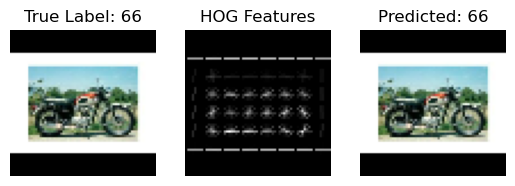

In [38]:
show_image_with_hog_features_and_prediction(X_test, y_test, classifier)